# Bank Marketing Effectiveness A/B Test with XGboost AWS Sagemaker

This study is accessing bank marketing strategies and their effectiveness in getting a subscription. It is a binary data set which specifies whether the induvidual subscribed or not. the Approach taken on this data was direct marketing which include direct phonecalls and emails and how many were sent out before if any subscription was made.

Features:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

-Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')



#### STEPS:
1. Transform data
2. Hyperparameter Tuning
3. Create experiments instance 
4. Create multi model end point
5. Deploy Endpoint
6. Invoke endpoints and results
7. Result Interpretation

In [1]:
import sagemaker, boto3

session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=session)
sagemaker_client = session.client('sagemaker')
role = sagemaker.get_execution_role()

In [2]:
import time, os, sys
import numpy as np
import pandas as pd
import itertools
from sklearn.preprocessing import LabelEncoder

from pprint import pprint

### 1. Transform data
Here the categorical data is one hot encoded to be in correct format for machine learing algorithm also the target variable is label encoded

In [3]:
bank_data = pd.read_csv('bank_data_target.csv')
bank_data = bank_data.drop(['month'],axis=1)
cols = ['y', 'job']
df = pd.get_dummies(bank_data, columns=['marital','education','default','housing','loan','contact',
                                      'poutcome'],drop_first=True)
df[cols] = df[cols].apply(LabelEncoder().fit_transform)
df = df.sample(frac=1)
all_dataset = df
df.head()

,y,age,job,balance,day,duration,campaign,pdays,previous,marital_married,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
617,0,31,4,36,27,105,2,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
162,0,41,0,-256,9,35,3,-1,0,0,...,0,0,0,0,1,0,1,0,0,1
336,0,33,1,-195,20,9,1,-1,0,1,...,0,0,0,0,0,0,1,0,0,1
460,0,55,10,383,6,343,3,-1,0,1,...,1,0,0,0,0,0,1,0,0,1
492,1,53,0,1796,16,295,1,91,2,1,...,0,0,0,0,0,1,0,0,1,0


In [142]:
df['y'].value_counts()

0    1059
1     141
Name: y, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(all_dataset, 
                                   test_size=0.15, 
                                   random_state=0)

training, validation = train_test_split(train_val, 
                                        test_size=0.25, 
                                        random_state=0)

In [6]:
!mkdir -p tmp

In [7]:
training.to_csv('tmp/training_data.csv', header=False, index=False)
validation.to_csv('tmp/validation_data.csv', header=False, index=False)
test.to_csv('tmp/test_data.csv', header=False, index=False)

In [8]:
test.to_csv('tmp/test_data2.csv', header=True, index=False)
test2 = pd.read_csv('tmp/test_data2.csv')
test_data2 = test2.drop(['y'],axis=1)
test_data2.to_csv('tmp/test_data2.csv', header=False, index=False)

In [9]:
s3_bucket = "lexy-ml-sagemaker"
prefix = "bank-project"
path = f"s3://{s3_bucket}/{prefix}/input"

In [10]:
!aws s3 cp tmp/training_data.csv {path}/training_data.csv
!aws s3 cp tmp/validation_data.csv {path}/validation_data.csv
!aws s3 cp tmp/test_data.csv {path}/test_data.csv

upload: tmp/training_data.csv to s3://lexy-ml-sagemaker/bank-project/input/training_data.csv
upload: tmp/validation_data.csv to s3://lexy-ml-sagemaker/bank-project/input/validation_data.csv
upload: tmp/test_data.csv to s3://lexy-ml-sagemaker/bank-project/input/test_data.csv


In [11]:
!pip install sagemaker-experiments

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [12]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [13]:
import random
import string

def generate_random_string():
    list_of_chars = random.choices(
        string.ascii_uppercase, 
        k=10)
    return ''.join(list_of_chars)

In [14]:
label = generate_random_string() 
training_experiment = Experiment.create(
    experiment_name = f"experiment-{label}",
    description     = "Experiment Description",
    sagemaker_boto_client=sagemaker_client)

## 2. Hyperparameter Tuning
in this study we intend looking to look into the effect learning rate will have on the model so two models are created with learning rate (ETA) of 0.3 and 0.8 respectively all other hyperparameters are held coabstnt for pricing and time effectiveness however Baysian tuning is another method of hyperparameter tuning that can also be efficient After testing the first set of hyperparameter values, hyperparameter tuning uses regression to choose the next set of hyperparameter values to test.

In [15]:
hyperparam_options = {
    'max_depth': [70],
    'eta': [0.3,0.9],
    'gamma': [4],
    'min_child_weight': [6],
    'subsample': [0.4],
    'num_round': [20],
    'objective': ['binary:logistic']
}

In [16]:
def prepare_hyperparam_variations(options):
    names, values = zip(*options.items())
    return [dict(zip(names, value)) 
            for value in itertools.product(*values)]

In [17]:
hyperparam_variations = prepare_hyperparam_variations(
    hyperparam_options
)

hyperparam_variations

[{'max_depth': 70,
  'eta': 0.3,
  'gamma': 4,
  'min_child_weight': 6,
  'subsample': 0.4,
  'num_round': 20,
  'objective': 'binary:logistic'},
 {'max_depth': 70,
  'eta': 0.9,
  'gamma': 4,
  'min_child_weight': 6,
  'subsample': 0.4,
  'num_round': 20,
  'objective': 'binary:logistic'}]

In [18]:
s3_bucket = 'lexy-ml-sagemaker'
prefix = "bank-project"
path = f"s3://{s3_bucket}/{prefix}/input"
training_path = f"{path}/training_data.csv" 
validation_path = f"{path}/validation_data.csv" 
output_path = f"s3://{s3_bucket}/{prefix}/output/"

In [19]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost', 
                     boto3.Session().region_name, 
                     version="0.90-2")
#container

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [20]:
from sagemaker.inputs import TrainingInput
    
s3_input_training = TrainingInput(training_path, 
                                  content_type="text/csv")

s3_input_validation = TrainingInput(validation_path, 
                                    content_type="text/csv")

In [21]:
with Tracker.create(
    display_name="xgboost-experiment-display-name", 
    artifact_bucket=s3_bucket,
    artifact_prefix=training_experiment.experiment_name,
    sagemaker_boto_client=sagemaker_client
) as experiment_tracker:    
    experiment_tracker.log_input(name="training-input", 
                                 media_type="s3/uri", 
                                 value=training_path)
    
    experiment_tracker.log_input(name="validation-input", 
                                 media_type="s3/uri", 
                                 value=validation_path)
    
    experiment_tracker.log_parameters(hyperparam_options)

In [22]:
experiment_tracker.__dict__

{'trial_component': TrialComponent(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f85b13ce3d0>,trial_component_name='TrialComponent-2022-04-03-003648-ltsv',display_name='xgboost-experiment-display-name',tags=None,trial_component_arn='arn:aws:sagemaker:us-east-1:837860013848:experiment-trial-component/trialcomponent-2022-04-03-003648-ltsv',response_metadata={'RequestId': 'a7744247-27e3-4f6b-9c5f-3f958b1424e7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'a7744247-27e3-4f6b-9c5f-3f958b1424e7', 'content-type': 'application/x-amz-json-1.1', 'content-length': '129', 'date': 'Sun, 03 Apr 2022 00:36:47 GMT'}, 'RetryAttempts': 0},parameters={'max_depth': [70], 'eta': [0.3, 0.9], 'gamma': [4], 'min_child_weight': [6], 'subsample': [0.4], 'num_round': [20], 'objective': ['binary:logistic']},input_artifacts={'training-input': TrialComponentArtifact(value='s3://lexy-ml-sagemaker/bank-project/input/training_data.csv',media_type='s3/uri'), 'validation-input': TrialCompo

## 3. Create Experiments Instances 

In [23]:
def track_and_generate_config(
    experiment_tracker, 
    experiment_name, 
    job_name, 
    random_string, 
    hyperparameters):
    
    tracker_display_name = f"trial-metadata-{random_string}"
    print(f"{label} Create Tracker: {tracker_display_name}")
    
    with Tracker.create(
        display_name=tracker_display_name,
        artifact_bucket="sagemaker-cookbook-bucket",
        artifact_prefix=f"{experiment_name}/{job_name}",
        sagemaker_boto_client=sagemaker_client
    ) as trial_tracker:
        
        trial_tracker.log_parameters(hyperparameters)

    trial_name = f'trial-{random_string}'
    print(f"Create Trial: {trial_name}")
    
    trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=experiment_name,
        sagemaker_boto_client=sagemaker_client)
    
    trial.add_trial_component(
        experiment_tracker.trial_component)
    time.sleep(1) 
    trial.add_trial_component(
        trial_tracker.trial_component)
    
    print(f"Prepare Experiment Configuration")

    return {
        "ExperimentName": experiment_name, 
        "TrialName": trial.trial_name,
        "TrialComponentDisplayName": job_name
    }

In [24]:
import time

experiment_name = training_experiment.experiment_name

for index, hyperparameters in enumerate(
    hyperparam_variations
):
    iteration = index + 1
    print(f"Iteration # {iteration}")
    label = f"[Iteration # {iteration}]"
    random_string = generate_random_string()
    job_name = f"job-{random_string}"
    
    print(f"{label} Track and Generate Config")
    experiment_config = track_and_generate_config(
        experiment_tracker=experiment_tracker,
        experiment_name=experiment_name,
        job_name=job_name,
        random_string=random_string,
        hyperparameters=hyperparameters)
    
    time.sleep(1)
    print(f"{label} Initialize Estimator")
    estimator = sagemaker.estimator.Estimator( 
        container,
        role,
        instance_count=1, 
        instance_type='ml.m5.large', 
        output_path=output_path, 
        hyperparameters=hyperparameters,
        enable_sagemaker_metrics = True,
        sagemaker_session=sagemaker_session
    )
    
    print(f"{label} Call fit() function")
    estimator.fit({'train': s3_input_training, 
                   'validation': s3_input_validation},
                   job_name = job_name, 
                   wait=False,
                   experiment_config=experiment_config)

Iteration # 1
[Iteration # 1] Track and Generate Config
[Iteration # 1] Create Tracker: trial-metadata-VVBCFBZAMR
Create Trial: trial-VVBCFBZAMR
Prepare Experiment Configuration


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: job-VVBCFBZAMR


[Iteration # 1] Initialize Estimator
[Iteration # 1] Call fit() function
Iteration # 2
[Iteration # 2] Track and Generate Config
[Iteration # 2] Create Tracker: trial-metadata-NIVHYNFKNN
Create Trial: trial-NIVHYNFKNN
Prepare Experiment Configuration


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: job-NIVHYNFKNN


[Iteration # 2] Initialize Estimator
[Iteration # 2] Call fit() function


In [25]:
experiment_name = training_experiment.experiment_name
experiment_name

'experiment-ANTTKPSAVL'

In [26]:
%store experiment_name

Stored 'experiment_name' (str)


In [27]:
job_name

'job-NIVHYNFKNN'

In [141]:
from sagemaker.session import Session
from sagemaker.lineage.visualizer import LineageTableVisualizer 
session = Session() 
viz = LineageTableVisualizer(session) 
viz.show(training_job_name="job-VVBCFBZAMR")

,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...r/bank-project/input/validation_data.csv,Input,DataSet,ContributedTo,artifact
1,s3://...ker/bank-project/input/training_data.csv,Input,DataSet,ContributedTo,artifact
2,68331...aws.com/sagemaker-xgboost:0.90-2-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...utput/job-VVBCFBZAMR/output/model.tar.gz,Output,Model,Produced,artifact


In [29]:
from sagemaker.session import Session
from sagemaker.lineage.visualizer import LineageTableVisualizer 
session = Session() 
viz = LineageTableVisualizer(session) 
viz.show(training_job_name="job-UGCHMWZEAH")

,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...r/bank-project/input/validation_data.csv,Input,DataSet,ContributedTo,artifact
1,s3://...ker/bank-project/input/training_data.csv,Input,DataSet,ContributedTo,artifact
2,68331...aws.com/sagemaker-xgboost:0.90-2-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...utput/job-UGCHMWZEAH/output/model.tar.gz,Output,Model,Produced,artifact


### Experiment Analysis

In [30]:
from sagemaker.analytics import ExperimentAnalytics

In [31]:
import sagemaker, boto3

session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=session)

experiment_analytics = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, 
    experiment_name=experiment_name,
)

experiment_details_df = experiment_analytics.dataframe()

In [33]:
import pandas as pd
from IPython.display import display

pd.options.display.max_columns = None
display(experiment_details_df)

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,eta,gamma,max_depth,min_child_weight,num_round,objective,subsample,train - MediaType,train - Value,validation - MediaType,validation - Value,Trials,Experiments,training-input - MediaType,training-input - Value,validation-input - MediaType,validation-input - Value
0,job-NIVHYNFKNN-aws-training-job,job-NIVHYNFKNN,arn:aws:sagemaker:us-east-1:837860013848:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.large,30.0,0.9,4,70,6,20,binary:logistic,0.4,text/csv,s3://lexy-ml-sagemaker/bank-project/input/trai...,text/csv,s3://lexy-ml-sagemaker/bank-project/input/vali...,[trial-NIVHYNFKNN],[experiment-ANTTKPSAVL],NaN,NaN,NaN,NaN
1,job-VVBCFBZAMR-aws-training-job,job-VVBCFBZAMR,arn:aws:sagemaker:us-east-1:837860013848:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.large,30.0,0.3,4,70,6,20,binary:logistic,0.4,text/csv,s3://lexy-ml-sagemaker/bank-project/input/trai...,text/csv,s3://lexy-ml-sagemaker/bank-project/input/vali...,[trial-VVBCFBZAMR],[experiment-ANTTKPSAVL],NaN,NaN,NaN,NaN
2,TrialComponent-2022-04-03-003710-bcwo,trial-metadata-NIVHYNFKNN,NaN,NaN,NaN,NaN,NaN,0.9,4,70,6,20,binary:logistic,0.4,NaN,NaN,NaN,NaN,[trial-NIVHYNFKNN],[experiment-ANTTKPSAVL],NaN,NaN,NaN,NaN
3,TrialComponent-2022-04-03-003708-xaqe,trial-metadata-VVBCFBZAMR,NaN,NaN,NaN,NaN,NaN,0.3,4,70,6,20,binary:logistic,0.4,NaN,NaN,NaN,NaN,[trial-VVBCFBZAMR],[experiment-ANTTKPSAVL],NaN,NaN,NaN,NaN
4,TrialComponent-2022-04-03-003648-ltsv,xgboost-experiment-display-name,NaN,NaN,NaN,NaN,NaN,"[0.3, 0.9]",[4],[70],[6],[20],['binary:logistic'],[0.4],NaN,NaN,NaN,NaN,"[trial-VVBCFBZAMR, trial-NIVHYNFKNN]","[experiment-ANTTKPSAVL, experiment-ANTTKPSAVL]",s3/uri,s3://lexy-ml-sagemaker/bank-project/input/trai...,s3/uri,s3://lexy-ml-sagemaker/bank-project/input/vali...


In [ ]:
from time import sleep

metric = "validation:error - Avg"
while metric not in experiment_details_df:
    experiment_details_df = experiment_analytics.dataframe()
    print("Not yet ready. Sleeping for 10 seconds")
    sleep(10)
    
print("Ready")

In [ ]:
target_fields = [
    "TrialComponentName",
    "DisplayName",
    "eta",
    "gamma",
    "max_depth",
    "min_child_weight",
    "num_round",
    "objective",
    "subsample",
    "validation:error - Avg",
    "train:error - Avg",
    "Trials",
    "Experiments",
]

experiment_summary_df = experiment_details_df[target_fields]

In [41]:
display(experiment_summary_df)

,TrialComponentName,DisplayName,eta,gamma,max_depth,min_child_weight,num_round,objective,subsample,validation:error - Avg,train:error - Avg,Trials,Experiments
0,job-WPPCFJUVNE-aws-training-job,job-WPPCFJUVNE,0.2,4,8,6,10,binary:logistic,0.4,0.124619,0.109659,[trial-WPPCFJUVNE],[experiment-FWESYYPZAV]
1,job-MPJFOCKQIU-aws-training-job,job-MPJFOCKQIU,0.2,3,8,6,10,binary:logistic,0.4,0.123039,0.108660,[trial-MPJFOCKQIU],[experiment-FWESYYPZAV]
2,TrialComponent-2022-04-02-160528-yixa,trial-metadata-WPPCFJUVNE,0.2,4,8,6,10,binary:logistic,0.4,NaN,NaN,[trial-WPPCFJUVNE],[experiment-FWESYYPZAV]
3,TrialComponent-2022-04-02-160525-luwm,xgboost-experiment-display-name,[0.2],"[3, 4]",[8],[6],[10],['binary:logistic'],[0.4],NaN,NaN,"[trial-WPPCFJUVNE, trial-MPJFOCKQIU]","[experiment-FWESYYPZAV, experiment-FWESYYPZAV]"
4,TrialComponent-2022-04-02-160525-ltya,trial-metadata-MPJFOCKQIU,0.2,3,8,6,10,binary:logistic,0.4,NaN,NaN,[trial-MPJFOCKQIU],[experiment-FWESYYPZAV]


In [42]:
import math

def is_not_nan(num):
    return not math.isnan(num)

def remove_nan_rows(df):
    return df[df['train:error - Avg'].map(is_not_nan)]

experiment_summary_df = remove_nan_rows(experiment_summary_df)

experiment_summary_df

,TrialComponentName,DisplayName,eta,gamma,max_depth,min_child_weight,num_round,objective,subsample,validation:error - Avg,train:error - Avg,Trials,Experiments
0,job-WPPCFJUVNE-aws-training-job,job-WPPCFJUVNE,0.2,4,8,6,10,binary:logistic,0.4,0.124619,0.109659,[trial-WPPCFJUVNE],[experiment-FWESYYPZAV]
1,job-MPJFOCKQIU-aws-training-job,job-MPJFOCKQIU,0.2,3,8,6,10,binary:logistic,0.4,0.123039,0.108660,[trial-MPJFOCKQIU],[experiment-FWESYYPZAV]


In [43]:
sorted_df = experiment_summary_df.sort_values('train:error - Avg', ascending=True)
sorted_df

,TrialComponentName,DisplayName,eta,gamma,max_depth,min_child_weight,num_round,objective,subsample,validation:error - Avg,train:error - Avg,Trials,Experiments
1,job-MPJFOCKQIU-aws-training-job,job-MPJFOCKQIU,0.2,3,8,6,10,binary:logistic,0.4,0.123039,0.108660,[trial-MPJFOCKQIU],[experiment-FWESYYPZAV]
0,job-WPPCFJUVNE-aws-training-job,job-WPPCFJUVNE,0.2,4,8,6,10,binary:logistic,0.4,0.124619,0.109659,[trial-WPPCFJUVNE],[experiment-FWESYYPZAV]


In [44]:
final_df = sorted_df[["DisplayName", "train:error - Avg"]]
final_df

,DisplayName,train:error - Avg
1,job-MPJFOCKQIU,0.108660
0,job-WPPCFJUVNE,0.109659


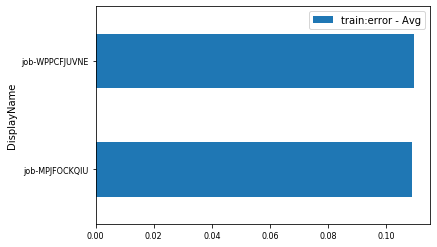

In [45]:
final_df.plot(kind='barh', x="DisplayName", fontsize=8)

In [36]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
role = get_execution_role()

In [37]:
from sagemaker.image_uris import retrieve

image_uri = retrieve(
    "xgboost", 
    region="us-east-1", 
    version="0.90-2"
)

image_uri

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

In [38]:
output_path

's3://lexy-ml-sagemaker/bank-project/output/'

In [39]:
model_a_s3_path = f"{output_path}job-NIVHYNFKNN/output/model.tar.gz"
model_b_s3_path = f"{output_path}job-VVBCFBZAMR/output/model.tar.gz"

In [40]:
from sagemaker.image_uris import retrieve

image_uri = retrieve(
    "xgboost", 
    region="us-east-1", 
    version="0.90-2"
)

image_uri

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

## 4. Create Multi-model Endpoint
This code uploads two pre-trained XGBoost models that are ready for you to deploy. If a pretrained model is in Amazon S3, it can be added by specifying the s3_key

In [41]:
image_uri_a = image_uri
image_uri_b = image_uri

In [42]:
container1 = { 
    'Image': image_uri_a,
    'ContainerHostname': 'containerA',
    'ModelDataUrl': model_a_s3_path
}

container2 = { 
    'Image': image_uri_b,
    'ContainerHostname': 'containerB',
    'ModelDataUrl': model_b_s3_path
}

In [43]:
model_name = "ab-testing"
endpoint_config_name = 'ab-testing-config'
endpoint_name = 'ab-testing-endpoint'

In [44]:
import boto3
sm_client = boto3.Session().client('sagemaker')

In [45]:
model_name_a = "ab-model-a"
model_name_b = "ab-model-b"
endpoint_config_name = 'ab-endpoint-config'
endpoint_name = 'ab-endpoint'

In [46]:
try:
    sm_client.delete_model(ModelName=model_name_a)
    sm_client.delete_model(ModelName=model_name_b)
except:
    pass

In [49]:
response = sm_client.create_model(
    ModelName        = model_name_a,
    ExecutionRoleArn = role,
    Containers       = [container1])
print(response)

response = sm_client.create_model(
    ModelName        = model_name_b,
    ExecutionRoleArn = role,
    Containers       = [container2])
print(response)

{'ModelArn': 'arn:aws:sagemaker:us-east-1:837860013848:model/ab-model-a', 'ResponseMetadata': {'RequestId': '7ebb8c19-887a-4aed-971a-57fa4498f15f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7ebb8c19-887a-4aed-971a-57fa4498f15f', 'content-type': 'application/x-amz-json-1.1', 'content-length': '72', 'date': 'Sun, 03 Apr 2022 00:40:55 GMT'}, 'RetryAttempts': 0}}
{'ModelArn': 'arn:aws:sagemaker:us-east-1:837860013848:model/ab-model-b', 'ResponseMetadata': {'RequestId': '9d938841-cb52-4011-8ed1-d0492a6dec22', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '9d938841-cb52-4011-8ed1-d0492a6dec22', 'content-type': 'application/x-amz-json-1.1', 'content-length': '72', 'date': 'Sun, 03 Apr 2022 00:40:56 GMT'}, 'RetryAttempts': 1}}


## 5. Deploy Endpoint

We now create two variants, each with its own different model (these could also have different instance types and counts).

We set an initial_weight of “1” for both variants: this means 50% of our requests go to Variant1, and the remaining 50% of all requests to Variant2. (The sum of weights across both variants is 2 and each variant has weight assignment of 1. This implies each variant receives 1/2, or 50%, of the total traffic.)

In [50]:
from sagemaker.session import production_variant

variant1 = production_variant(
    model_name=model_name_a,
    instance_type="ml.t2.medium",
    initial_instance_count=1,
    variant_name='VariantA',
    initial_weight=0.5
)
                              
variant2 = production_variant(
    model_name=model_name_b,
    instance_type="ml.t2.medium",
    initial_instance_count=1,
    variant_name='VariantB',
    initial_weight=0.5
)

In [51]:
session.endpoint_from_production_variants(
    name=endpoint_name,
    production_variants=[variant1, variant2]
)

INFO:sagemaker:Creating endpoint with name ab-endpoint


---------------------!

'ab-endpoint'

In [52]:
runtime_sm_client = boto3.client('sagemaker-runtime')

## 6. Invoke Endpoints and Results
Data is sent to endpoint to get inferences in real time.

In [69]:
from time import sleep

prediction1 = []
def test_ab_testing_setup():
    with open("tmp/test_data2.csv", "r") as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip("\n")
            response = runtime_sm_client.invoke_endpoint(EndpointName=endpoint_name, 
                                                         ContentType="text/csv", Body=payload,
                                                        TargetVariant='VariantA')
            time.sleep(0.5)

            variant = response['InvokedProductionVariant']
            b = response['Body'].read()
            prediction = b.decode("utf-8")
            prediction1.append(prediction)

        print(variant + " - "+ prediction)

for _ in range(0,1):
    test_ab_testing_setup()
    sleep(1)

....................................................................................................................................................................................VariantA - 0.0432015024125576


## 7. Result Interpretation

Determining Metrics
1. F1 score
2. PR-Curve
3. ROC-AUC curve

The dataset is imbalaced however SMOTE oversampling was not applied on the data so the metric that shows the overall performance is the F1 score since it is a balance of the precision and recall. The F1 score for the critical class (class 1 which were customers that subscribed) was 0.46 for the Variant A and 0.16 for Variant B. 

An important chart that can be used to access the variants are precision and recall curve which makes it possible to assess the performance of a classifier on the minority class. Both the precision and the recall are focused on the positive class (the minority class) and are unconcerned with the true negatives (majority class). Hence The focus of the PR curve on the minority class makes it an effective diagnostic for imbalanced binary classification models. Here the Variant A and Variant B both did not perform well however it can be noted that Variant B seems to have a more steep slope which may indicate better performance of Variant A.

The ROC-AUC curve is very effective at direct comparison between two models for performance. Although this metric is generally better suited for binary classification with balanced data it is very effective for comparison between models. in PR-curve it was not very clear which model performed better, however after looking at the ROC-AUC we see that Variant A is clearly better since Variants B slope is extremly close to the diagonal line indicating the model is finding it hard to differentiate between positive and negative class.

Variant A is the best performing model from these 2 Variants. However more analysis is needed before model can be registered and deployed. Some future steps include running bayesian hyperparameter search for AWS Sagemaker to find overall best parameters for analysis. Additional data especially on for the positive class if obtainde will enhance performance. If no data can be obtained SMOTE (synthetic minority oversampling technique) should be applied with restraint to create synthetic positive samples. After these steps are taken more traffic can be routed to the better performing model for more analysis before model registration.


In [ ]:
pred1 = list(map(float, prediction1))
label = test['y']
arr1 = np.asarray(pred1)

In [130]:
from sklearn.metrics import classification_report
target_names =['not subscribed', 'subscribed',]
# Convert to binary predictions
threshold = 0.5
preds1 = np.where(arr1 > threshold, 1, 0)
print(classification_report(label, preds1, target_names=target_names))

                precision    recall  f1-score   support

not subscribed       0.92      0.97      0.94       158
    subscribed       0.62      0.36      0.46        22

      accuracy                           0.89       180
     macro avg       0.77      0.67      0.70       180
  weighted avg       0.88      0.89      0.88       180



AUC is 0.666


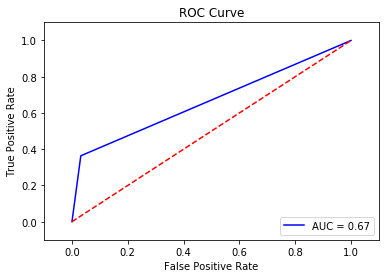

In [137]:
from sklearn import metrics 
import matplotlib.pyplot as plt
auc = round(metrics.roc_auc_score(label, preds1), 4)
print("AUC is " + repr(auc))


fpr, tpr, _ = metrics.roc_curve(label, preds1)

plt.title("ROC Curve")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

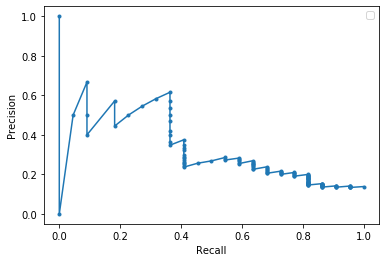

In [161]:
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(label, pred1)

pyplot.plot(recall, precision, marker='.')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [127]:
from time import sleep

predictions2 = []
def test_direct_call():
    with open("tmp/test_data2.csv", "r") as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip("\n")
            response = runtime_sm_client.invoke_endpoint(EndpointName=endpoint_name, 
                                                         ContentType="text/csv", Body=payload,
                                                        TargetVariant='VariantB')
            time.sleep(0.5)

            variant = response['InvokedProductionVariant']
            b = response['Body'].read()
            prediction = b.decode("utf-8")
            predictions2.append(prediction)

        print(variant + " - "+ prediction)

for _ in range(0,1):
    test_direct_call()
    sleep(1)

....................................................................................................................................................................................VariantB - 0.02623940445482731


In [128]:
pred2 = list(map(float, predictions2))
arr2 = np.asarray(pred2)
preds2 = np.where(arr2 > threshold, 1, 0)
print(classification_report(label, preds2, target_names=target_names))

                precision    recall  f1-score   support

not subscribed       0.89      0.99      0.94       158
    subscribed       0.67      0.09      0.16        22

      accuracy                           0.88       180
     macro avg       0.78      0.54      0.55       180
  weighted avg       0.86      0.88      0.84       180



AUC is 0.5423


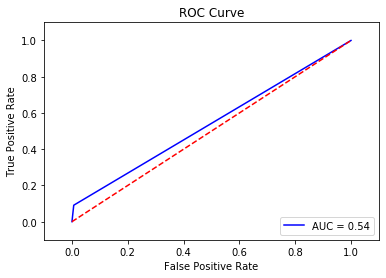

In [138]:
from sklearn import metrics 
import matplotlib.pyplot as plt
auc = round(metrics.roc_auc_score(label, preds2), 4)
print("AUC is " + repr(auc))


fpr, tpr, _ = metrics.roc_curve(label, preds2)

plt.title("ROC Curve")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

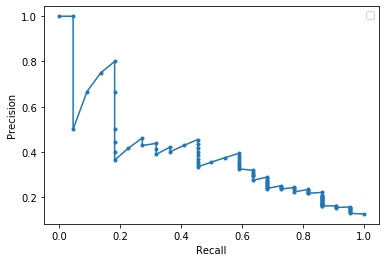

In [160]:
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(label, pred2)

pyplot.plot(recall, precision, marker='.')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [139]:
response = sm_client.delete_endpoint(
    EndpointName=endpoint_name
)

response

{'ResponseMetadata': {'RequestId': 'ff899b8e-24e3-424c-a2a0-92539f784e7a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ff899b8e-24e3-424c-a2a0-92539f784e7a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 03 Apr 2022 03:10:03 GMT'},
  'RetryAttempts': 0}}